In [4]:
import numpy as np
import scripts
import matplotlib.pyplot as plt
import stoclust as sc
import matplotlib.lines as ln
from tqdm import tqdm

import scipy.linalg as la
import os

import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
rc('font',**{'family':'cmr10','size':20})
rc('text', usetex=1)

# Initializiation

In [5]:
gtap = scripts.GTAP()
num_reg = gtap.regions.items.size
num_commod = gtap.commodities.items.size
num_fac = gtap.factors.items.size

In [6]:
new_reg = gtap.megaregions.at_scale(1)
new_commod = gtap.commodities.at_scale(2)
new_fac = gtap.factors.at_scale(2)

num_new_reg = new_reg.clusters.size
num_new_commod = new_commod.clusters.size
num_new_fac = new_fac.clusters.size

# Varying the trade deficit

We now summon the null models drawn over a varying trade deficit parameter. For a given set of parameter values and a given unobtainium distribution $\hat{e}^{(\mathrm{U})}_{ri}$, we calculate the average dismajorization overall and the null likelihood of net exports for each region. We then make density plots for these values, where the density is taken over all sampled unobtainium distributions $\hat{e}^{(\mathrm{U})}_{ri}$.

In [7]:
val_flows_null = np.load('scripts/data/computed/flows/null_deficit/values.npy',)
unb_in_null = sc.utils.stoch(np.load('scripts/data/computed/flows/null_deficit/unobtainium_in.npy',),axis=2)
unb_out_null = sc.utils.stoch(np.load('scripts/data/computed/flows/null_deficit/unobtainium_out.npy',),axis=2)


In [8]:
unb_in_reg = unb_in_null.reshape([1000,1000,num_new_reg,num_new_commod]).sum(axis=3)
unb_out_reg = unb_out_null.reshape([1000,1000,num_new_reg,3]).sum(axis=3)

In [96]:
from scipy.special import kl_div
intensities = np.zeros([1000,num_new_reg])
is_exporting = np.zeros([1000,num_new_reg,4])
avg_exports = np.zeros([1000,num_new_reg,4])
dismaj_by_res = np.zeros([1000])
dismaj_by_net = np.zeros([1000])


for i in tqdm(range(1000)):
    val_reg_null = val_flows_null[i].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)
    val_attr_reg_null = val_flows_null[i].sum(axis=0).reshape([num_new_reg,3]).sum(axis=1)
    for j in range(1000):
        intensities[j,:] = unb_in_reg[j,i]/val_reg_null
        xi = unb_in_reg[j,i] - unb_out_reg[j,i]
        is_exporting[j,:,int(i/250)] += (xi>0)
        dismaj = scripts.dismajorization(unb_in_reg[j,i],val_reg_null,unb_out_reg[j,i],val_reg_null)
        dismaj_by_res[j] += dismaj
        dismaj_by_net[i] += dismaj

100%|██████████| 1000/1000 [16:57<00:00,  1.02s/it]


We plot the two density functions.

In [98]:
linestyle=['-','--','-.',':']
labels=[r'$2^0$',r'$2^{1}$',r'$2^{2}$',r'$2^{3}$']

fig,ax = plt.subplots(1,2,figsize=(12,6))
x = np.arange(0.001,1,0.001)

for j in range(0,4):
    #hist,bins = np.histogram(dismaj_by_net[j*250:(j+1)*250]/1000,bins=10,density=True)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit((dismaj_by_net[j*250:(j+1)*250]/1000)[:,np.newaxis])
    ax[0].plot(
        x,np.exp(kde.score_samples(x[:,None])),
        linestyle=linestyle[j],color='k',label=labels[j]
    )
    ax[0].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)

ax[0].legend(loc='upper right')
ax[0].set_xscale('log')
#ax.set_yscale('log')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Average dismajorization')


Text(0.5, 0, 'Average dismajorization')

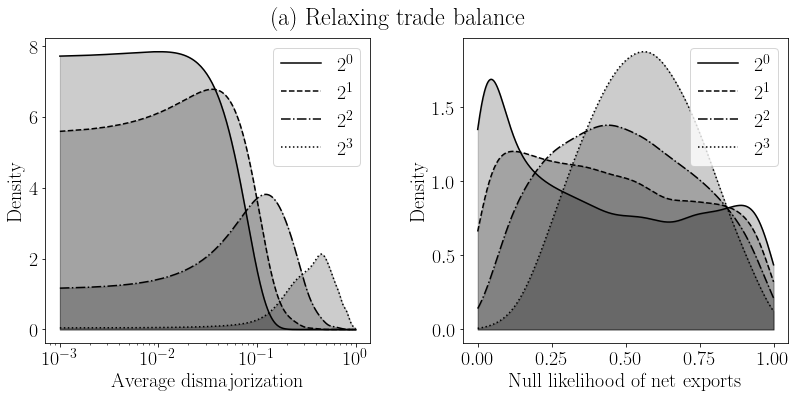

In [99]:
from sklearn.neighbors import KernelDensity
x = np.arange(0,1,0.001)

linestyle=['-','--','-.',':']
labels=[r'$2^0$',r'$2^{1}$',r'$2^{2}$',r'$2^{3}$']
j = 0
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(is_exporting[:,:,j].flatten()[:,np.newaxis]/250)
ax[1].plot(x,np.exp(kde.score_samples(x[:,None])),linestyle=linestyle[j],color='k',label=labels[j])
ax[1].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)
j = 1
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(is_exporting[:,:,j].flatten()[:,np.newaxis]/250)
ax[1].plot(x,np.exp(kde.score_samples(x[:,None])),linestyle=linestyle[j],color='k',label=labels[j])
ax[1].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)
j = 2
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(is_exporting[:,:,j].flatten()[:,np.newaxis]/250)
ax[1].plot(x,np.exp(kde.score_samples(x[:,None])),linestyle=linestyle[j],color='k',label=labels[j])
ax[1].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)

j = 3
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(is_exporting[:,:,j].flatten()[:,np.newaxis]/250)
ax[1].plot(x,np.exp(kde.score_samples(x[:,None])),linestyle=linestyle[j],color='k',label=labels[j])
ax[1].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)

ax[1].set_ylabel(r'Density')
ax[1].set_xlabel(r'Null likelihood of net exports')

fig.tight_layout(pad=2.0)
plt.suptitle('(a) Relaxing trade balance')
ax[1].legend(loc='upper right')
plt.savefig('plots/trade_balance.pdf',bbox_inches='tight')
plt.show()

# Varying Heterogeneity

We do the same now for the null models with varying heterogeneity parameters.

In [78]:
val_flows_null = np.load('scripts/data/computed/flows/null_unobtainium/values.npy',)
unb_in_null = sc.utils.stoch(np.load('scripts/data/computed/flows/null_unobtainium/unobtainium_in.npy',),axis=2)
unb_out_null = sc.utils.stoch(np.load('scripts/data/computed/flows/null_unobtainium/unobtainium_out.npy',),axis=2)


In [79]:
unb_in_reg = unb_in_null.reshape([1000,1000,num_new_reg,num_new_commod]).sum(axis=3)
unb_out_reg = unb_out_null.reshape([1000,1000,num_new_reg,3]).sum(axis=3)

In [80]:
from scipy.special import kl_div
intensities = np.zeros([1000,num_new_reg])
is_exporting = np.zeros([1000,num_new_reg])
dismaj_by_res = np.zeros([1000])
dismaj_by_net = np.zeros([1000])


for i in tqdm(range(1000)):
    val_reg_null = val_flows_null[i].sum(axis=1).reshape([num_new_reg,num_new_commod]).sum(axis=1)
    val_attr_reg_null = val_flows_null[i].sum(axis=0).reshape([num_new_reg,3]).sum(axis=1)
    for j in range(1000):
        intensities[j,:] = unb_in_reg[j,i]/val_reg_null
        xi = unb_in_reg[j,i] - unb_out_reg[j,i]
        is_exporting[j,:] += (xi>0)
        dismaj = scripts.dismajorization(unb_in_reg[j,i],val_reg_null,unb_out_reg[j,i],val_reg_null)
        dismaj_by_res[j] += dismaj
        dismaj_by_net[i] += dismaj

100%|██████████| 1000/1000 [20:13<00:00,  1.21s/it]


In [92]:
linestyle=['-','--','-.',':']
labels=[r'$2^0$',r'$2^{1}$',r'$2^{2}$',r'$2^{3}$']

fig,ax = plt.subplots(1,2,figsize=(12,6))
x = np.arange(0.001,1,0.001)

for j in range(0,4):
    #hist,bins = np.histogram(dismaj_by_net[j*250:(j+1)*250]/1000,bins=10,density=True)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit((dismaj_by_res[j*250:(j+1)*250]/1000)[:,np.newaxis])
    ax[0].plot(
        x,np.exp(kde.score_samples(x[:,None])),
        linestyle=linestyle[j],color='k',label=labels[j]
    )
    ax[0].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)

ax[0].legend(loc='upper right')
ax[0].set_xscale('log')
#ax.set_yscale('log')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Average dismajorization')


Text(0.5, 0, 'Average dismajorization')

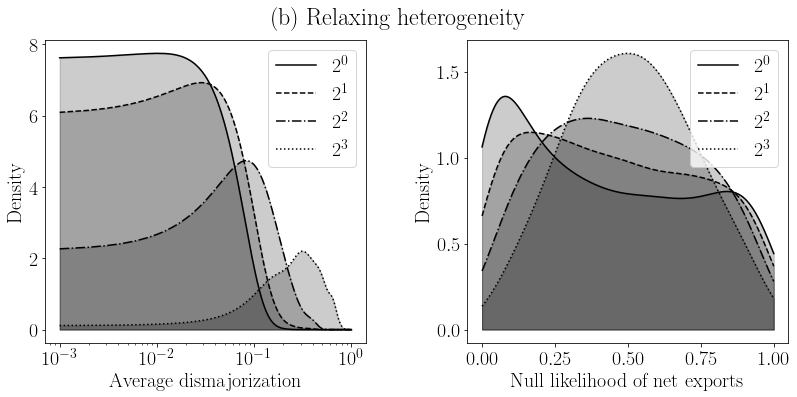

In [93]:
from sklearn.neighbors import KernelDensity
x = np.arange(0,1,0.001)

linestyle=['-','--','-.',':']
labels=[r'$2^0$',r'$2^{1}$',r'$2^{2}$',r'$2^{3}$']
j = 0
kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(is_exporting[250*j:250*(j+1)].flatten()[:,np.newaxis]/1000)
ax[1].plot(x,np.exp(kde.score_samples(x[:,None])),linestyle=linestyle[j],color='k',label=labels[j])
ax[1].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)
j = 1
kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(is_exporting[250*j:250*(j+1)].flatten()[:,np.newaxis]/1000)
ax[1].plot(x,np.exp(kde.score_samples(x[:,None])),linestyle=linestyle[j],color='k',label=labels[j])
ax[1].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)
j = 2
kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(is_exporting[250*j:250*(j+1)].flatten()[:,np.newaxis]/1000)
ax[1].plot(x,np.exp(kde.score_samples(x[:,None])),linestyle=linestyle[j],color='k',label=labels[j])
ax[1].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)

j = 3
kde = KernelDensity(kernel='gaussian', bandwidth=0.08).fit(is_exporting[250*j:250*(j+1)].flatten()[:,np.newaxis]/1000)
ax[1].plot(x,np.exp(kde.score_samples(x[:,None])),linestyle=linestyle[j],color='k',label=labels[j])
ax[1].fill_between(x,0,np.exp(kde.score_samples(x[:,None])),color='k',alpha=0.2)

ax[1].set_ylabel(r'Density')
ax[1].set_xlabel(r'Null likelihood of net exports')

fig.tight_layout(pad=2.0)
plt.suptitle('(b) Relaxing heterogeneity')
ax[1].legend(loc='upper right')
plt.savefig('plots/heterogeneity.pdf',bbox_inches='tight')
plt.show()